Data generated with MIparInd12.py (MI11 noise is MI12)
```python
import tensorflow as tf
from functionsTF import *
from functions import *
from IO import *
import time
import numpy as np
from io import BytesIO
import mutual_info
import gc

DEVICE = '/cpu:0'
i=0
p = Pool(nodes=56)
params = []
for T in [60000, 10000, 6000]:
    for both in [True, False]:
        for N in [400]:
            for sG in [0,10,20,50]:
                for tauv in np.arange(15,95,5):
                    i+=1
                    params.append([T, both, N, sG, tauv, i])


def runFn(things):
    F = 10
    T, both, N, sG, tauv, i = things
    apple = generateInput(2, T, F)
    pear = generateInput(3, T, F)
    print('*'*80)
    print('%d / %d'%(i,3*2*1*4*16))
    ### input 1: apple
    gpu1 = Tfnet(N=N,T=T, disp=False, tauv=tauv, sG=sG, device=DEVICE, both=both, spikeMonitor=False)
    gpu1.input = apple
    gpu1.runTFSimul()
    apple_out = gpu1.vvm[-1000:]
    
    ### input 2: pear
    disp=False
    gpu2 = Tfnet(N=N,T=T, disp=False, tauv=tauv, sG=sG, device=DEVICE, both=both, spikeMonitor=False)
    gpu2.input = pear
    gpu2.runTFSimul()
    pear_out = gpu2.vvm[-1000:]

    filename = "MI11-both-%s_tauv-%d_sg-%d_N-%d_input-%s_T-%d_F-%d" % (str(both), tauv,sG, N, 'test', T, F)
    with open(filename, 'wb') as f:
        np.savez(f,vvmN1 = gpu1.vvmN1, vvmN2 = gpu1.vvmN2, vvm = gpu1.vvm,
                vvmN1_2 = gpu2.vvmN1, vvmN2_2 = gpu2.vvmN2, vvm_2 = gpu2.vvm)
    del gpu1
    del gpu2
    gc.collect()

p.map(runFn, params)
```

In [2]:
import tensorflow as tf
from functionsTF import *
from functions import *
from IO import *

%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
import seaborn as sns
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [3]:
import mutual_info

In [4]:
N = 400
T = 10000

DEVICE = '/cpu:0'

In [5]:
scaling = 1 / (1 / (2 * 2 / 0.25)) ** 0.5 * 70
def generateInput2(seed, T, n=None):
    dt = 0.25
    np.random.seed(seed)
    x = np.linspace(0.0, dt*T, T)
    signal = np.zeros(len(x))
    iBack = 0
    for i in range(len(x)):
        iBack = iBack + dt / 2 * (-iBack + np.random.rand()-0.5)
        iEff = iBack * scaling +  260
        signal[i] = iEff
    return signal

(0, 100)

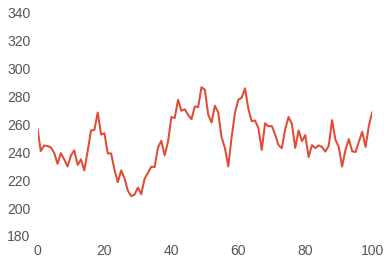

In [6]:
plt.plot(generateInput2(2, T))
plt.xlim([0,100])

In [7]:
# disp = True
# tauv = 45
# sG = 50
# N = N
# both=False

# ### input 1: apple
# gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, device=DEVICE, both=both)
# apple = generateInput(3, T)
# gpu.input = apple
# gpu.both = True
# gpu.runTFSimul()
# apple_out = gpu.vvm[-1000:]

In [8]:
# plt.plot(gpu.vvmN2)

In [9]:
# # plt.plot(gpu.vvmN1)
# # plt.plot(gpu.vvmN2)
# print(mutual_info.mutual_information_2d((gpu.vvmN1), (gpu.vvmN2)))
# print(np.corrcoef(gpu.vvmN1,gpu.vvmN2)[0,1])

In [10]:
# for T in [4000, 8000, 60000]:
#     for both in [True, False]:
#         for N in [400]:
#             for sG in [0,10,20,50]:
#                 for tauv in np.arange(15,95,5):
#                     ### input 1: apple
#                     disp=False
#                     gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, device=DEVICE, both=both, spikeMonitor=False)
#                     np.random.seed(2)
#                     gpu.input = apple
#                     gpu.runTFSimul()
#                     apple_out = gpu.vvm[-1000:]

#                     filename = "MI_both-%s_tauv-%d_sg-%d_N-%d_input-%s_T=%d" % (str(both), tauv,sG, N, 'test', T)
#                     with open(filename, 'wb') as f:
#                         np.savez(f,vvmN1 = gpu.vvmN1, vvmN2 = gpu.vvmN2, 
#                                 cor1 = np.corrcoef(gpu.vvmN1[100:1100], gpu.vvmN2[100:1100])[0,1], 
#                                 cor2 = np.corrcoef(gpu.vvmN1[-1001:-1], gpu.vvmN2[-1001:-1])[0,1],
# #                                 mutual_info.mutual_information_2d((gpu.vvmN1[100:1100]), (gpu.vvmN2[100:1100])),
# #                                 mutual_info.mutual_information_2d((gpu.vvmN1[-1001:-1]), (gpu.vvmN2[-1001:-1]))
#                                 )

In [24]:
df = pd.DataFrame(columns=('tauv', 'sG', 'both', 'T', 'N', 
                           'corN1_apple', 'corN2_apple','corN1_pear', 'corN2_pear', 'corChange_apple', 'corChange_pear', 
                           'm1s', 'm1e','m2s', 'm2e', 'mChangeN1', 'mChangeN2',
                           'm1s_pear', 'm1e_pear', 'm2s_pear', 'm2e_pear', 'mChangeN1_pear', 'mChangeN2_pear',
                          'mBaseline_s', 'mBaseline_e', 'mBaseline_change',
                          'mBaseline_s_N2', 'mBaseline_e_N2', 'mBaseline_change_N2',
                          'mInter_s', 'mInter_e', 'mInter_change',
                          'mInput1_s', 'mInput1_e', 'mInput1_change',
                          'mInput2_s', 'mInput2_e', 'mInput2_change') )
i=-1
d = 500
sigma = 1
for T in [6000, 10000, 60000]:
    apple = generateInput(2, T, 60)
    pear = generateInput(3, T, 60)
    for both in [ False, True]:
        for N in [400]:
            for sG in [0,10,20,50]:
                for tauv in np.arange(15,95,5):
#                     try:
                        i+=1
                        filename = "../data/MI11/MI11-both-%s_tauv-%d_sg-%d_N-%d_input-%s_T-%d" % (str(both), tauv,sG, N, 'noise', T)
                        a = np.load(filename)
                        cor1 = np.corrcoef(a['vvmN1'][100:100+d], a['vvmN2'][100:100+d])[0,1]
                        cor2 = np.corrcoef(a['vvmN1'][T-d:T], a['vvmN2'][T-d:T])[0,1]
                        cor1_2 = np.corrcoef(a['vvmN1_2'][100:100+d], a['vvmN2_2'][100:100+d])[0,1]
                        cor2_2 = np.corrcoef(a['vvmN1_2'][T-d:T], a['vvmN2_2'][T-d:T])[0,1]
                        corChange = cor2/cor1
                        corChange_2 = cor2_2/cor1_2

                        # m1x: MI between apple input and output network 1 with apple input
                        m1s = float(mutual_info.mutual_information_2d((apple[100:100+d]), (a['vvmN1'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        m1e = float(mutual_info.mutual_information_2d((apple[T-d:T]), (a['vvmN1'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))
                        # m2x: MI between apple input and output network 2 with apple input
                        m2s = float(mutual_info.mutual_information_2d((apple[100:100+d]), (a['vvmN2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        m2e = float(mutual_info.mutual_information_2d((apple[T-d:T]), (a['vvmN2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))
                        mChangeN1 = m1e/m1s
                        mChangeN2 = m2e/m2s
                        
                        # m1x_pear: MI between pear input and output network 1 with pear input
                        m1s_pear = float(mutual_info.mutual_information_2d((pear[100:100+d]), (a['vvmN1_2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        m1e_pear = float(mutual_info.mutual_information_2d((pear[T-d:T]), (a['vvmN1_2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))
                        # m2x_pear: MI between pear input and output network 2 with pear input
                        m2s_pear = float(mutual_info.mutual_information_2d((pear[100:100+d]), (a['vvmN2_2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        m2e_pear = float(mutual_info.mutual_information_2d((pear[T-d:T]), (a['vvmN2_2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))
                        mChangeN1_pear = m1e_pear/m1s_pear
                        mChangeN2_pear = m2e_pear/m2s_pear
                        
                        
                        # mBaseline: MI between pear input and output network 1 with pear input
                        mBaseline_s = float(mutual_info.mutual_information_2d((apple[100:100+d]), (a['vvmN1_2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        mBaseline_e = float(mutual_info.mutual_information_2d((apple[T-d:T]), (a['vvmN1_2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))

                        mBaseline_change = mBaseline_e/mBaseline_s
                        
                        # mBaseline: MI between pear input and output network 1 with pear input
                        mBaseline_s_N2 = float(mutual_info.mutual_information_2d((apple[100:100+d]), (a['vvmN2_2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        mBaseline_e_N2 = float(mutual_info.mutual_information_2d((apple[T-d:T]), (a['vvmN2_2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))

                        mBaseline_change_N2 = mBaseline_e_N2/mBaseline_s_N2
                        
                        # mInter: inter coherence
                        mInter_s = float(mutual_info.mutual_information_2d((a['vvmN1'][100:100+d]), (a['vvmN2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        mInter_e = float(mutual_info.mutual_information_2d((a['vvmN1'][T-d:T]), (a['vvmN2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))

                        mInter_change = mInter_e/mInter_s
                        
                        # mInput: test coherence after presenting different inputs
                        mInput1_s = float(mutual_info.mutual_information_2d((a['vvmN1'][100:100+d]), (a['vvmN1_2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        mInput1_e = float(mutual_info.mutual_information_2d((a['vvmN1'][T-d:T]), (a['vvmN1_2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))

                        mInput1_change = mInput1_e/mInput1_s
                        
                        mInput2_s = float(mutual_info.mutual_information_2d((a['vvmN2'][100:100+d]), (a['vvmN2_2'][100:100+d]), 
                                                                     normalized=False, sigma=sigma) )
                        mInput2_e = float(mutual_info.mutual_information_2d((a['vvmN2'][T-d:T]), (a['vvmN2_2'][T-d:T]), 
                                                                    normalized=False, sigma=sigma))

                        mInput2_change = mInput2_e/mInput2_s

                        
    #                     df.loc[i] = [int(tauv), int(sG), bool(both), int(T), int(N), float(a['cor1']), float(a['cor2']) ]
                        df.loc[i] = [int(tauv), int(sG), bool(both), int(T), int(N), 
                                     cor1, cor2, cor1_2, cor2_2,
                                     corChange, corChange_2, 
                                     m1s, m1e, m2s, m2e, mChangeN1, mChangeN2,
                                     m1s_pear, m1e_pear, m2s_pear, m2e_pear, mChangeN1_pear, mChangeN2_pear,
                                    mBaseline_s, mBaseline_e, mBaseline_change,
                                    mBaseline_s_N2, mBaseline_e_N2, mBaseline_change_N2,
                                    mInter_s, mInter_e, mInter_change,
                                    mInput1_s, mInput1_e, mInput1_change,
                                    mInput2_s, mInput2_e, mInput2_change]
#                     except:
#                         pass

In [25]:
# both = True
# tauv=85
# sG = 10
# N = 400
# filename = "MI4-both-%s_tauv-%d_sg-%d_N-%d_input-%s_T=%d" % (str(both), tauv,sG, N, 'test', T)
# a = np.load(filename)
# plt.plot(a['vvmN2'][100:])
# # df[df['tauv']==15].tail()

In [26]:
df.to_csv(DIRECTORY + 'MI12.csv')

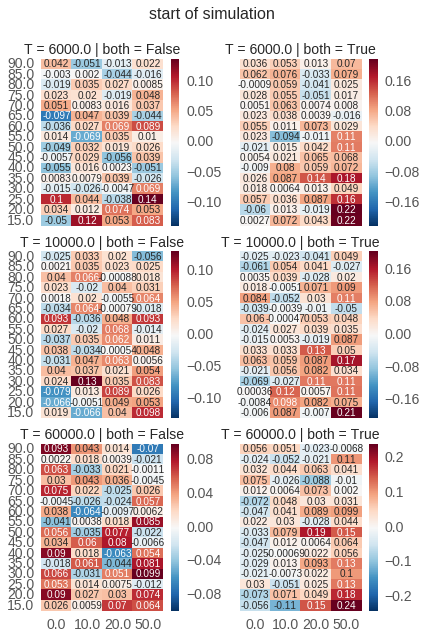

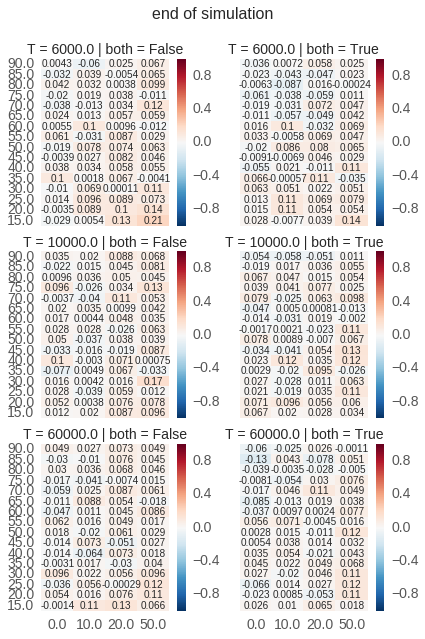

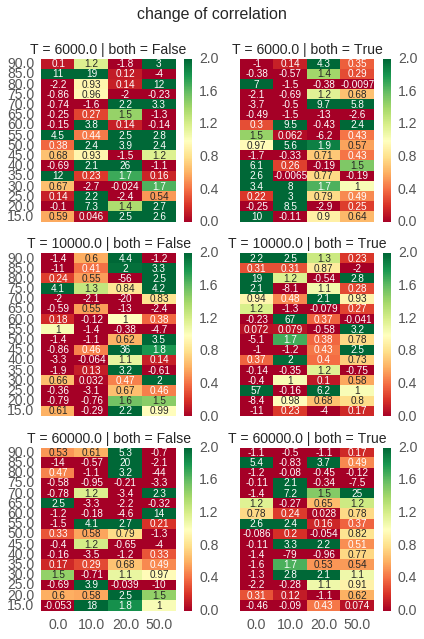

In [27]:
cols = ['corN1_apple', 'corN2_apple','corChange_apple']
plotGrid(df, 'corN1_apple', 'start of simulation', cmap="RdBu_r", cols=cols)
plotGrid(df, 'corN2_apple', 'end of simulation', cmap="RdBu_r", vmin=-.1, vmax=1.0, cols=cols)
plotGrid(df, 'corChange_apple', 'change of correlation',  cmap="RdYlGn", norm=MidpointNormalize(midpoint=1.), vmin=0, vmax=2, cols=cols)

In [28]:
vmin = 0.4
vmax = 0.8
vminc = 0.8
vmaxc = 2.7

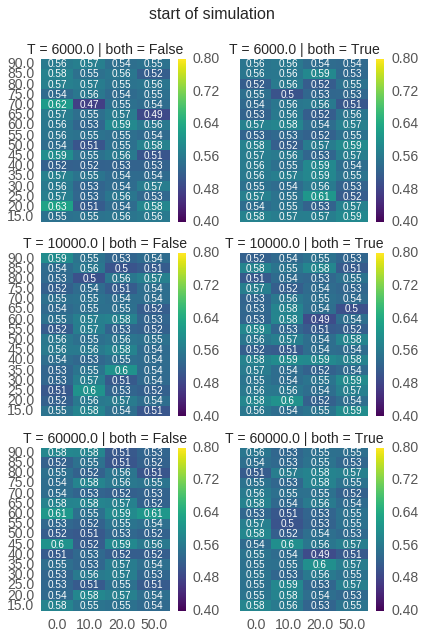

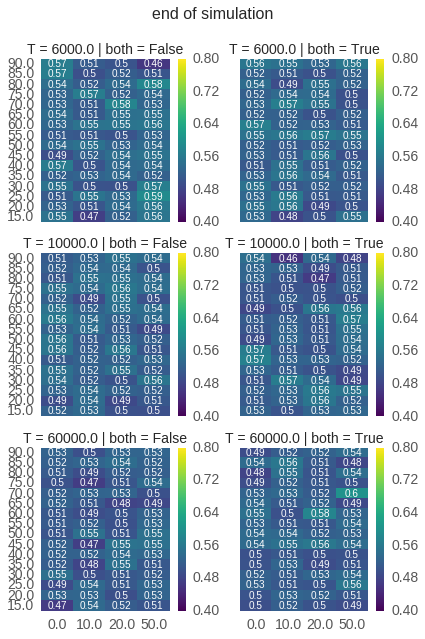

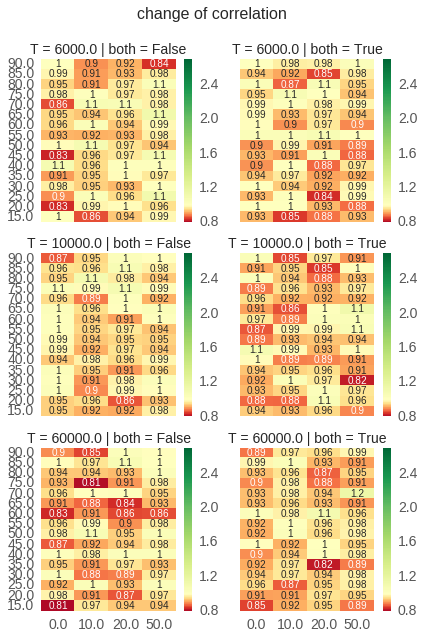

In [29]:
plotGrid(df, 'm1s', 'start of simulation', cmap="viridis", cols = ['m1s', 'm1e', 'mChangeN1'], vmin=vmin, vmax=vmax)
plotGrid(df, 'm1e', 'end of simulation', cmap="viridis", cols = ['m1s', 'm1e', 'mChangeN1'], vmin=vmin, vmax=vmax)
plotGrid(df, 'mChangeN1', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = ['m1s', 'm1e', 'mChangeN1'], vmin=vminc, vmax=vmaxc)

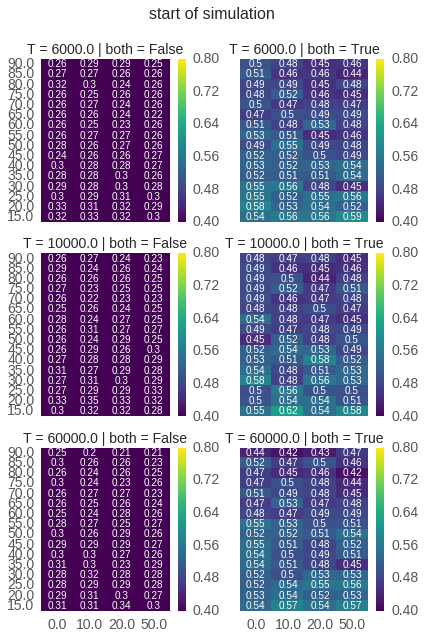

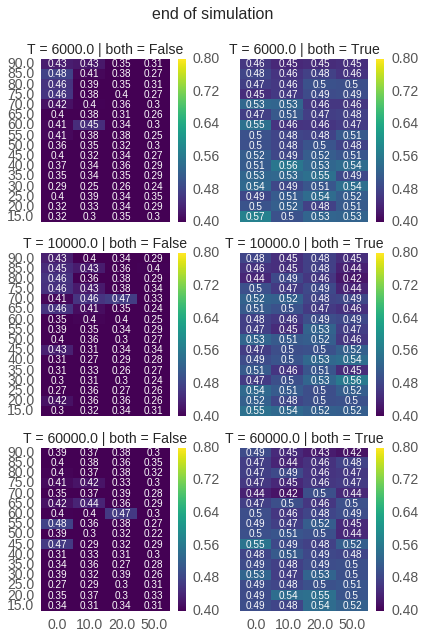

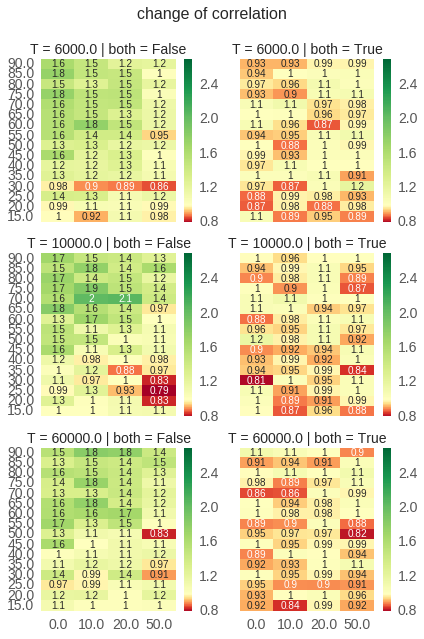

In [30]:
plotGrid(df, 'm2s', 'start of simulation', cmap="viridis", cols = ['m2s', 'm2e', 'mChangeN2'], vmin=vmin, vmax=vmax)
plotGrid(df, 'm2e', 'end of simulation', cmap="viridis", cols = ['m2s', 'm2e', 'mChangeN2'], vmin=vmin, vmax=vmax)
plotGrid(df, 'mChangeN2', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = ['m2s', 'm2e', 'mChangeN2'], vmin=vminc, vmax=vmaxc)

## BASELINES
* Coherence between S1 and O_N1(S2)
* Coherence between S1 and O_N2(S2)

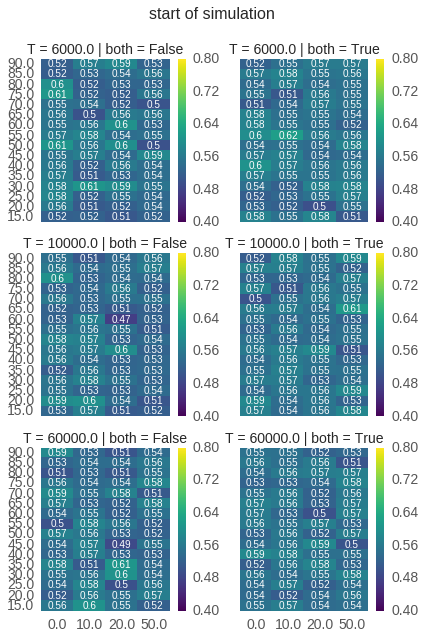

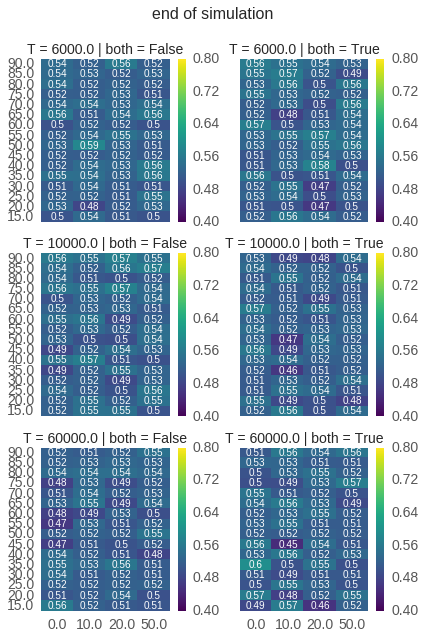

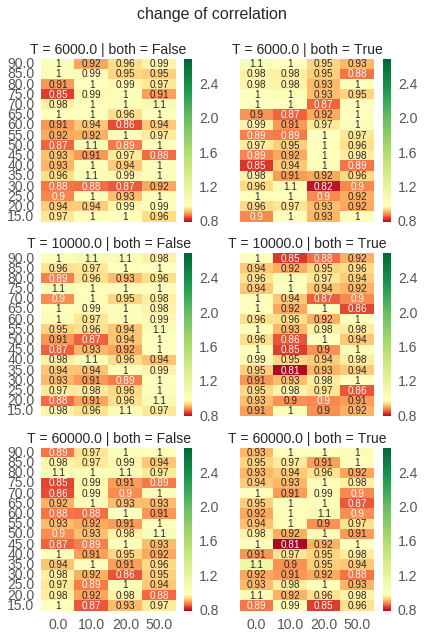

In [31]:
# vmin=None
# vmax=None
# vminc=None
# vmaxc=None
plotGrid(df, 'mBaseline_s', 'start of simulation', cmap="viridis", cols = ['mBaseline_s', 'mBaseline_e', 'mBaseline_change'], vmin=vmin, vmax=vmax)
plotGrid(df, 'mBaseline_e', 'end of simulation', cmap="viridis", cols = ['mBaseline_s', 'mBaseline_e', 'mBaseline_change'], vmin=vmin, vmax=vmax)
plotGrid(df, 'mBaseline_change', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = ['mBaseline_s', 'mBaseline_s', 'mBaseline_change'], vmin=vminc, vmax=vmaxc)

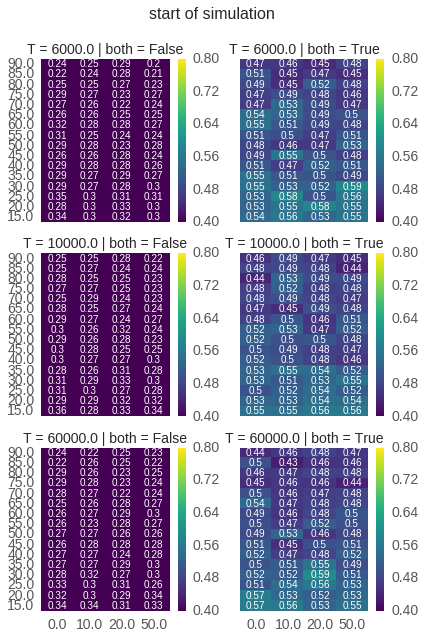

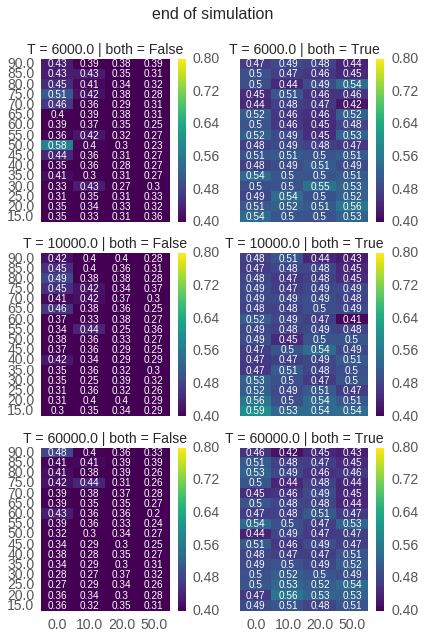

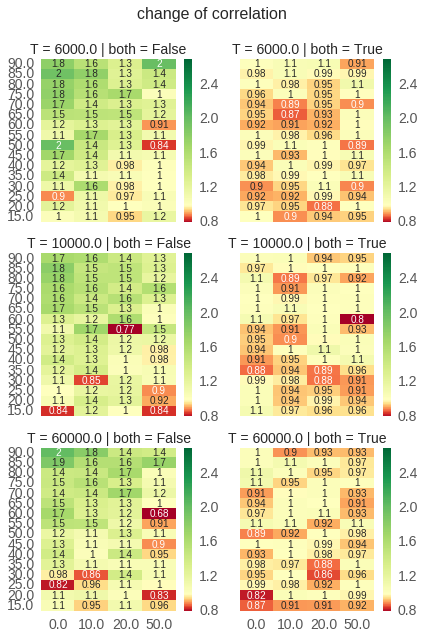

In [32]:
# vmin=None
# vmax=None
# vminc=None
# vmaxc=None
cols = ['mBaseline_s_N2', 'mBaseline_e_N2', 'mBaseline_change_N2']
plotGrid(df, 'mBaseline_s_N2', 'start of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mBaseline_e_N2', 'end of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mBaseline_change_N2', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = cols, vmin=vminc, vmax=vmaxc)

## Coherence after presenting different inputs
* O_N1(S1) <-> O_N1(S2)
* O_N2(S1) <-> O_N2(S2)

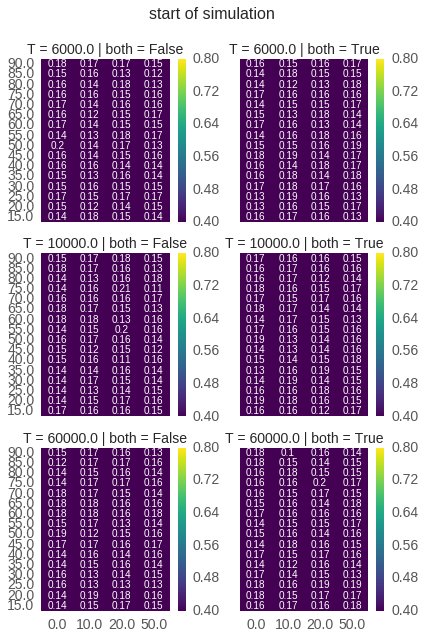

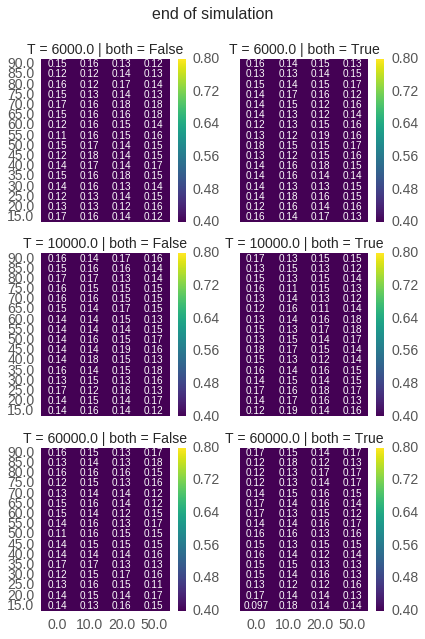

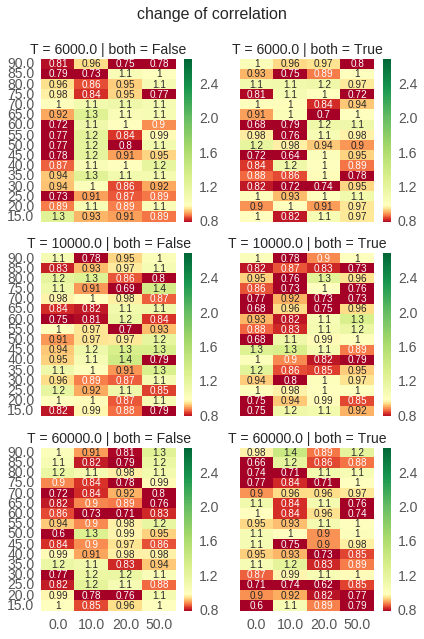

In [33]:
cols = ['mInput1_s', 'mInput1_e', 'mInput1_change']
plotGrid(df, 'mInput1_s', 'start of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mInput1_e', 'end of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mInput1_change', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = cols, vmin=vminc, vmax=vmaxc)

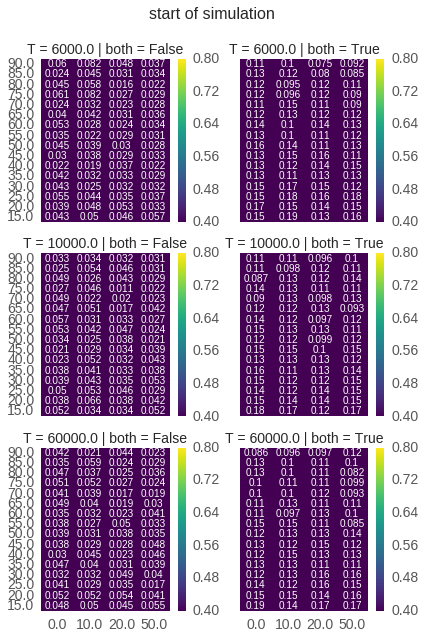

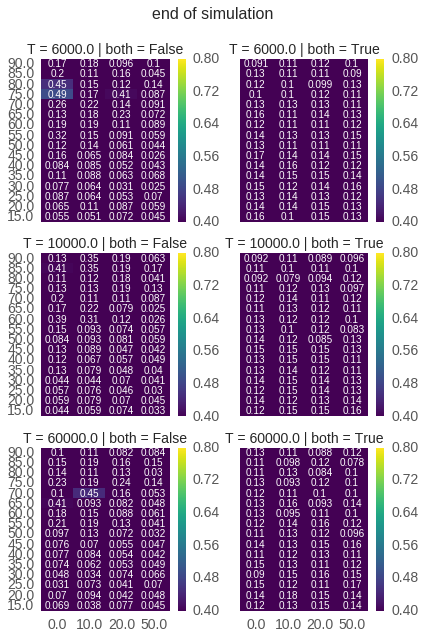

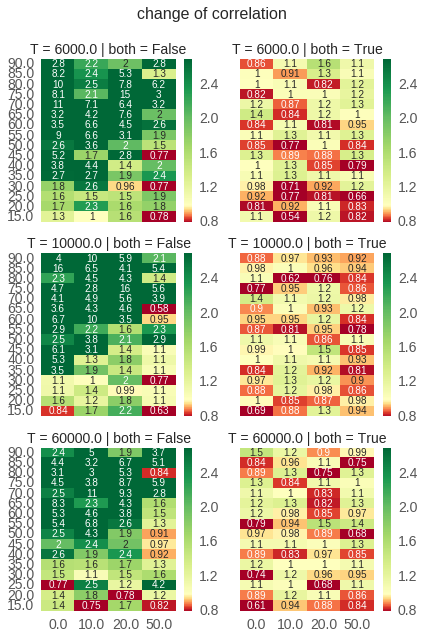

In [34]:
cols = ['mInput2_s', 'mInput2_e', 'mInput2_change']
plotGrid(df, 'mInput2_s', 'start of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mInput2_e', 'end of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mInput2_change', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = cols, vmin=vminc, vmax=vmaxc)

## Coherence between N1 and N2

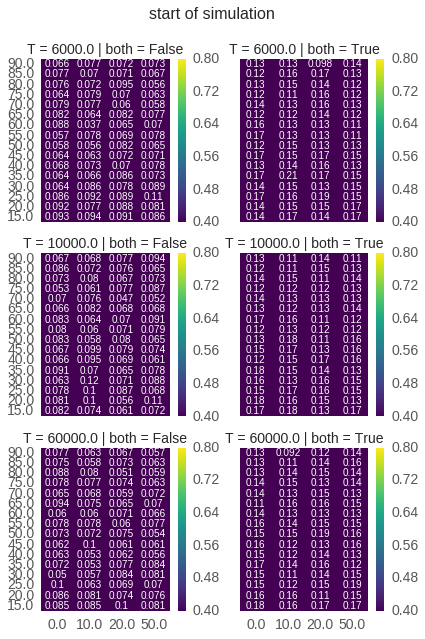

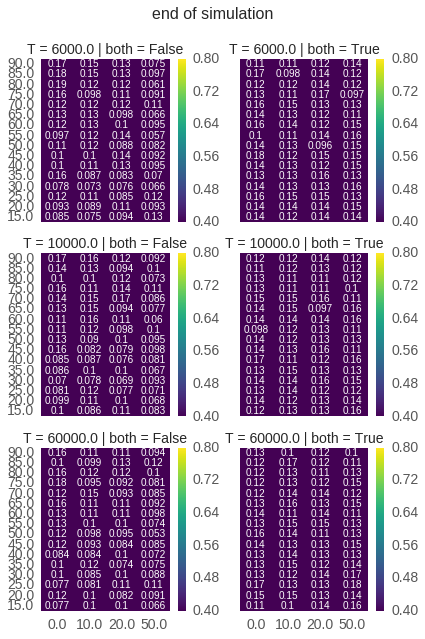

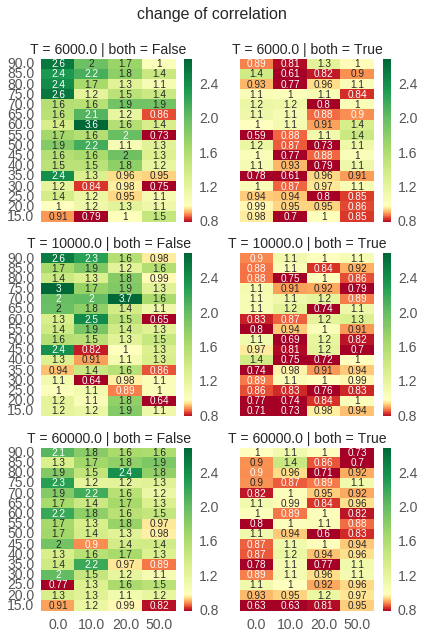

In [35]:
cols = ['mInter_s', 'mInter_e', 'mInter_change']
plotGrid(df, 'mInter_s', 'start of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mInter_e', 'end of simulation', cmap="viridis", cols = cols, vmin=vmin, vmax=vmax)
plotGrid(df, 'mInter_change', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = cols, vmin=vminc, vmax=vmaxc)

## Fourier

/mnt/DATA/gp1514/Projects/github/cortex/notebooks/functions.py:186: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  plt.plot(xf, 2.0/dt * np.abs(yf[0:T/2]))


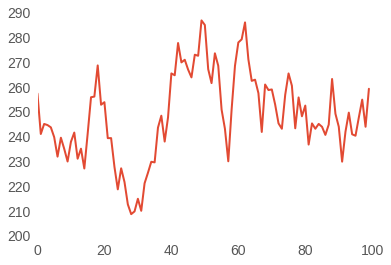

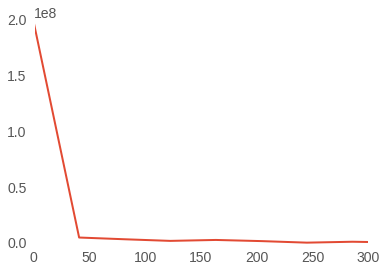

In [37]:
T = 100
apple = generateInput2(2, T, 10)
plt.plot(apple)
plt.savefig(DIRECTORY + 'apple.png')
plotFFT(apple, T)
plt.savefig(DIRECTORY + 'appleFFT.png')

/mnt/DATA/gp1514/Projects/github/cortex/notebooks/functions.py:186: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  plt.plot(xf, 2.0/dt * np.abs(yf[0:T/2]))


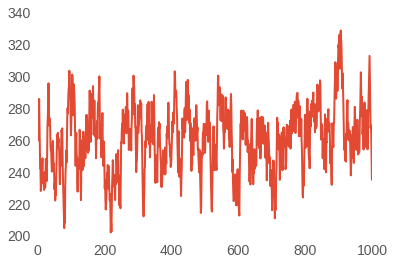

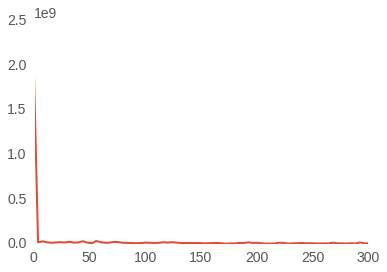

In [42]:
T = 1000
apple = generateInput2(3, T, 10)
plt.plot(apple)
plt.savefig(DIRECTORY + 'pear.png')
plotFFT(apple, T)
plt.savefig(DIRECTORY + 'pearFFT.png')

In [19]:
H, xedges, yedges = np.histogram2d(gpu.vvmN1, gpu.vvmN2, bins=(256,256))
im = plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

NameError: name 'gpu' is not defined

In [ ]:
apple = generateInput(3, T, 10)
pear = generateInput(3, T, 10)

# apple=np.random.randn(2,50000)
# pear = apple*2
mutual_info.mutual_information_2d(apple.ravel(),pear.ravel(), normalized=1)

In [ ]:
mod15 = resonanceFS(tauv=30)
F = np.logspace(0.5, 2.3, 200)
plt.semilogx(F, mod15/ np.nanmax(mod15), label='%.1f' % (F[np.argmax(mod15)]), color='c')
plt.legend()

In [ ]:
plt.plot(np.fft.rfft(generateInput(2, T, 60)))
plt.plot(np.fft.rfft(generateInput(3, T, 60)))
plt.xlim([0,4000])

In [ ]:
dt = 0.25
x = np.linspace(0.0, dt*T, T)
applefft = np.fft.rfft(generateInput(2, T, 60))
plt.plot(x[:len(applefft)],applefft)
plt.xlim([0,1000])
